# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: `s3://sta9760-yelpdataset/yelp-light/*business.json`

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install `pandas` and `matplotlib`

In [1]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.11.0")
sc.install_pypi_package("scipy==1.5.4")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
5,application_1606229628628_0006,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl

  Usi

## Importing

Now, import the installed packages from the previous block below.

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data

We are finally ready to load data. Using `spark` load the data from S3 into a `dataframe` object that we can manipulate further down in our analysis.

In [3]:
business = spark.read.json('s3://sta9760-project2-yelpdataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Overview of Data

Display the number of rows and columns in our dataset.

In [4]:
num_rows = business.count()
num_cols = len(business.columns)
print('Columns:', num_cols, "| Rows:", num_rows)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209393

Display the DataFrame schema below.

In [5]:
business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* `business_id`
* `name`
* `city`
* `state`
* `categories`

In [6]:
business.select("business_id", "name", "city", "state", "categories").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as `Active Life`, for instance
* What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [7]:
from pyspark.sql.functions import explode, split

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
business_categories = business.select("business_id", "categories")
business_categories_exploded = business_categories.withColumn('categories', explode(split('categories', ", ")))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Display the first 5 rows of your association table below.

In [9]:
business_categories_exploded.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|      categories|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [10]:
business_categories_exploded.select('categories').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business

Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category

So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |

Or something to that effect.

In [11]:
business_categories_exploded.groupby('categories').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|      Paddleboarding|   36|
|      Dermatologists|  341|
|        Aerial Tours|   28|
|         Hobby Shops|  828|
|          Bubble Tea|  720|
|             Embassy|   13|
|             Tanning|  938|
|            Handyman|  682|
|      Aerial Fitness|   29|
|             Falafel|  159|
|       Outlet Stores|  399|
|        Summer Camps|  318|
|     Clothing Rental|   55|
|      Sporting Goods| 2311|
|     Cooking Schools|  118|
|  College Counseling|   15|
|  Lactation Services|   50|
|Ski & Snowboard S...|   50|
|             Museums|  359|
|              Doulas|   45|
+--------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories

With this data available, let us now build a barchart of the top 20 categories. 

**HINT**: don't forget about the matplotlib magic!

```
%matplot plt
```

In [12]:
barchart_business = business_categories_exploded.groupby('categories').count().orderBy('count', ascending=False)
pdf = barchart_business.limit(20).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

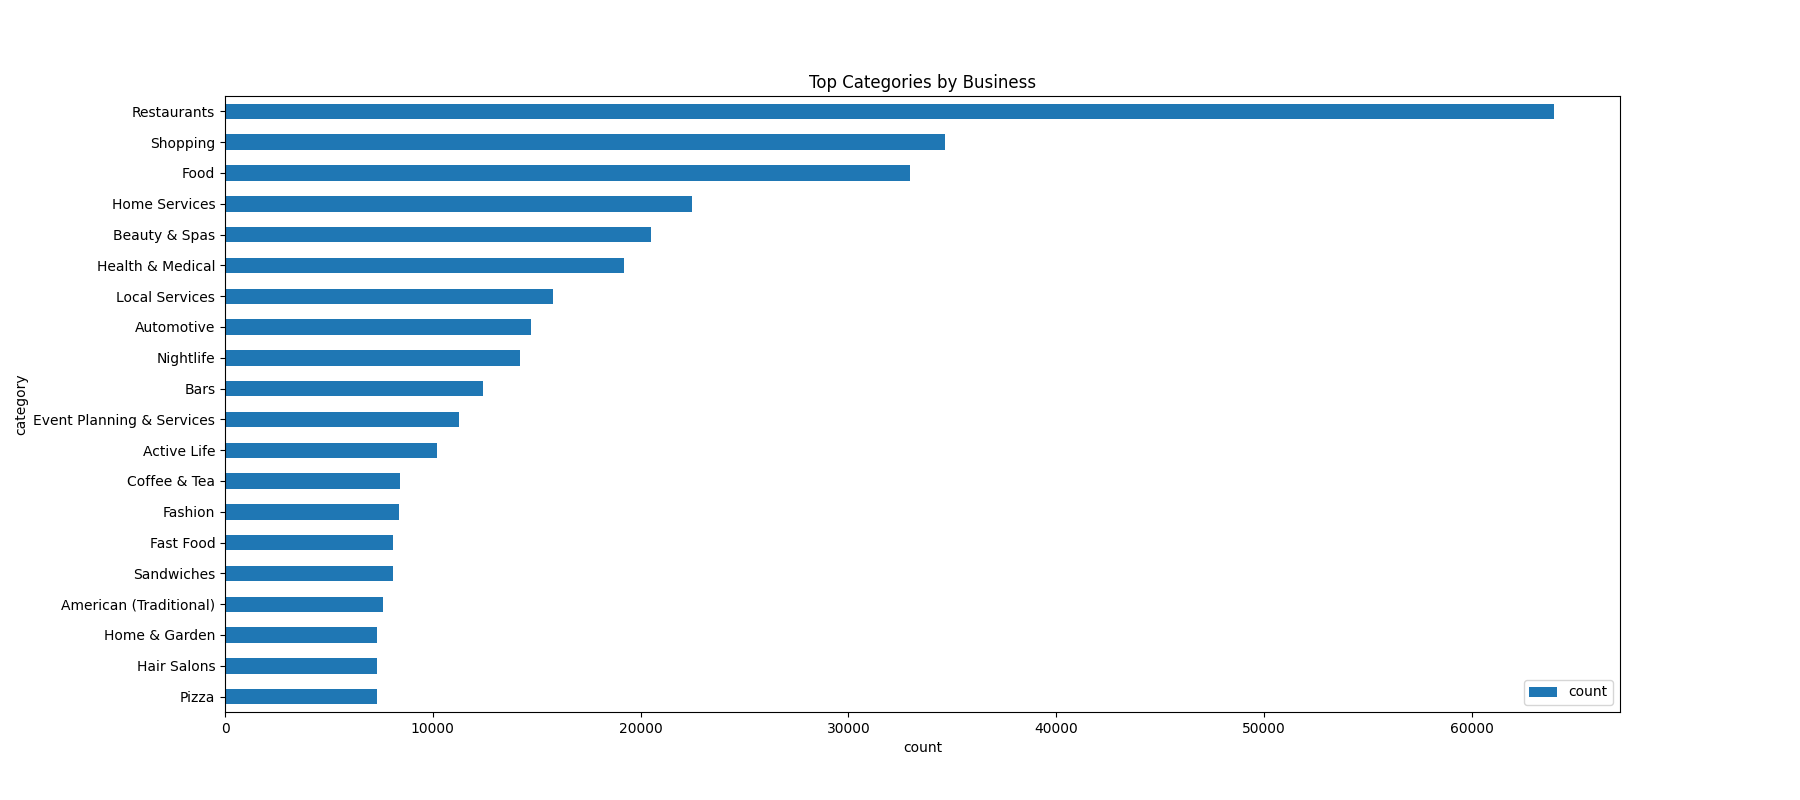

In [13]:
pdf = pdf.sort_values('count', ascending=True)
pdf.plot(kind='barh', x='categories', y='count', figsize=(18, 8))
plt.title('Top Categories by Business')
plt.xlabel('count')
plt.ylabel('category')

%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely _dissatisfied_ or extremely _satisfied_ with the service received. 

How true is this really? Let's try and answer this question.

## Loading User Data

Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [14]:
review = spark.read.json('s3://sta9760-project2-yelpdataset/yelp_academic_dataset_review.json')
review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the `business_id` and `stars` columns together for the user reviews data.

In [15]:
review.select('business_id', 'stars').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the `stars` column to get a resultant dataframe that displays _average stars_ per business as accumulated by users who **took the time to submit a written review**.

In [16]:
from pyspark.sql.functions import length
from pyspark.sql.functions import col

written_reviews = review.select('business_id', 'user_id', 'stars', 'text').where(length(col("text")) > 0)
avg_stars = written_reviews.groupby("business_id").avg("stars")
avg_stars.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|ipFreSFhjClfNETuM...|               2.6|
|dLDMU8bOLnkDTmPUr...| 4.942857142857143|
|Qm2datcYBPXrPATVG...| 4.352941176470588|
+--------------------+------------------+
only showing top 5 rows

Now the fun part - let's join our two dataframes (reviews and business data) by `business_id`. 

In [17]:
business = business.join(avg_stars, 'business_id', 'inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's see a few of these:

In [18]:
business.select('avg(stars)', 'stars', 'name', 'city', 'state').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+--------------------+---------+-----+
|      avg(stars)|stars|                name|     city|state|
+----------------+-----+--------------------+---------+-----+
|4.11784140969163|  4.0|Delmonico Steakhouse|Las Vegas|   NV|
|             4.5|  4.5|Mr. Pancho Mexica...|     Mesa|   AZ|
|            3.75|  4.0|Maricopa County D...|  Phoenix|   AZ|
|             4.0|  4.0|Double Play Sport...|Las Vegas|   NV|
|          2.6875|  2.5|  Impressions Dental| Chandler|   AZ|
+----------------+-----+--------------------+---------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [19]:
skew_df = business.select('avg(stars)', 'stars', 'name', 'city', 'state').withColumn('skew', (col('avg(stars)') - col('stars')) / col('stars'))
skew_df.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+----------+-----+--------------------+
|        avg(stars)|stars|                name|      city|state|                skew|
+------------------+-----+--------------------+----------+-----+--------------------+
|  4.11784140969163|  4.0|Delmonico Steakhouse| Las Vegas|   NV|0.029460352422907565|
|               4.5|  4.5|Mr. Pancho Mexica...|      Mesa|   AZ|                 0.0|
|              3.75|  4.0|Maricopa County D...|   Phoenix|   AZ|             -0.0625|
|               4.0|  4.0|Double Play Sport...| Las Vegas|   NV|                 0.0|
|            2.6875|  2.5|  Impressions Dental|  Chandler|   AZ|               0.075|
| 4.976744186046512|  5.0|   Kidz Cuts By Lori| Henderson|   NV|-0.00465116279069...|
|3.8107142857142855|  4.0|Río Mirage Café y...| El Mirage|   AZ|-0.04732142857142...|
|3.7941176470588234|  4.0|   Steep & Brew West|   Madison|   WI|-0.05147058823529416|
|1.4762931034482758|  1.5|      Showtime Tours| Las Ve

And finally, graph it!

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

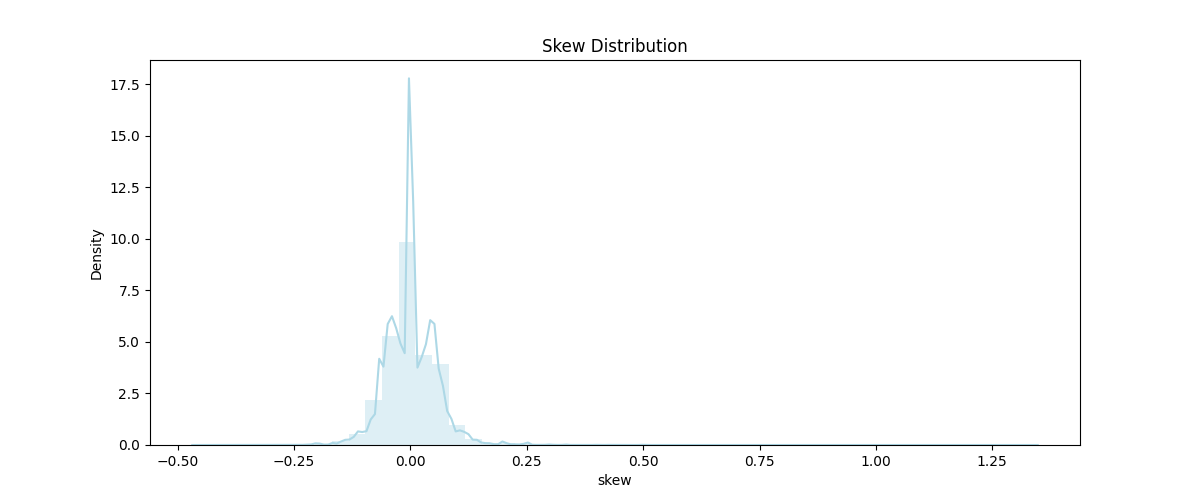

In [20]:
pd_skew = skew_df.toPandas()
fig = plt.figure(figsize=(12,5))
ax = sns.distplot(pd_skew['skew'], hist=True, kde=True, color = 'lightblue').set_title('Skew Distribution')
plt.show()
%matplot plt

So, do Yelp (written) Reviews skew negative? Does this analysis actually prove anything? Expound on implications / interpretations of this graph. 

From this distribution, we can see that the Yelp reviews are skewed to the left. If the skew number is 0, it means that the reviews are neutral and not skewed. However, there are many more reviews with negative skew numbers. Thus, reviewers who left a written response were more dissatisfied than normal

# Should the Elite be Trusted? (Or, some other analysis of your choice)

For the final portion - you have a choice:

* Try and analyze some interesting dimension to this data. The **ONLY** requirement is that you must use the **Users** dataset and join on either the **business* or **reviews** dataset
* Or, you may try and answer the question posed: how accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

Feel free to use any and all methodologies at your disposal - only requirement is you must render one visualization in your analysis

In [21]:
user = spark.read.json('s3://sta9760-project2-yelpdataset/yelp_academic_dataset_user.json')
user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [22]:
user.select('user_id', 'average_stars', 'elite').show(5, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-------------+--------------------------------------------+
|user_id               |average_stars|elite                                       |
+----------------------+-------------+--------------------------------------------+
|ntlvfPzc8eglqvk92iDIAw|3.57         |                                            |
|FOBRPlBHa3WPHFB5qYDlVg|3.84         |2008,2009,2010,2011,2012,2013               |
|zZUnPeh2hEp0WydbAZEOOg|3.44         |2010                                        |
|QaELAmRcDc5TfJEylaaP8g|3.08         |2009                                        |
|xvu8G900tezTzbbfqmTKvA|4.37         |2009,2010,2011,2012,2014,2015,2016,2017,2018|
+----------------------+-------------+--------------------------------------------+
only showing top 5 rows

### Create the elite user subset from the total user dataset

In [23]:
import pyspark.sql.functions as F
df = user.select('user_id', 'average_stars', 'elite').withColumn("length_of_elite", F.length("elite"))
df.show(truncate=False)
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+-------------+--------------------------------------------+---------------+
|user_id               |average_stars|elite                                       |length_of_elite|
+----------------------+-------------+--------------------------------------------+---------------+
|ntlvfPzc8eglqvk92iDIAw|3.57         |                                            |0              |
|FOBRPlBHa3WPHFB5qYDlVg|3.84         |2008,2009,2010,2011,2012,2013               |29             |
|zZUnPeh2hEp0WydbAZEOOg|3.44         |2010                                        |4              |
|QaELAmRcDc5TfJEylaaP8g|3.08         |2009                                        |4              |
|xvu8G900tezTzbbfqmTKvA|4.37         |2009,2010,2011,2012,2014,2015,2016,2017,2018|44             |
|z5_82komKV3mI4ASGe2-FQ|2.88         |2007                                        |4              |
|ttumcu6hWshk_EJVWrduDg|4.0          |                                            |0              |


In total, there are 1968703 users in this dataset.

In [24]:
elite = user.select('user_id', 'elite').where(length(col("elite")) > 0)
elite.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

75961

There is a total of 75961 elite users throughout the years in this dataset. <br>
### Join elite user dataset with review dataset on user_id to find out the reviews they have submitted:

In [25]:
elite_reviews = elite.join(review, 'user_id', 'inner')
elite_reviews.select('business_id', 'user_id', 'review_id', 'stars').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+-----+
|         business_id|             user_id|           review_id|stars|
+--------------------+--------------------+--------------------+-----+
|-8F04F54iDT6VgWPC...|1Dul59QEe-Q-7OQHT...|Kg5ncegiJ3utWRxDt...|  4.0|
|p2OOk46G_AOO0nCWl...|3pMczoCBOSKBcqMhV...|nBNDv9j_tiPPo5MMe...|  5.0|
|jyFoxS8MofdpkAAK6...|jO44Apni7iJZVVK4H...|EI6L-L0Dcj6HAUaBO...|  1.0|
|ewty6EB70nwPJsUkA...|RO78oDy7vbEcOJU8a...|Ryohf9HJcpk2C49vf...|  4.0|
|0M3KCmdY-_xlIu5vE...|TFxeEvpjMNQ3AWL49...|Lc0Tj-Me2Jwu_V9au...|  5.0|
|-h0o-BilkKaCa7HX9...|Fl1oTs6usaCfyjLnY...|GORTMUfkTtGViv4ap...|  5.0|
|DEtOIjhV0MWZ8fD8-...|RO78oDy7vbEcOJU8a...|aULkXMFrsMvctmJ5Q...|  5.0|
|Jt28TYWanzKrJYYr0...|LEr8vS6PRymCg-SJH...|JfNrW6b2mgcynJ3w2...|  2.0|
|NFm869_w6cvVaWaNp...|M7vDDzoPNQDN2FdTc...|OcaQAzflKbxKLS2rT...|  5.0|
|Da6eZFThE9xanUAGN...|Ania9MCwET-TBzVjV...|wuNIHeqK_pjpE4Hrp...|  4.0|
+--------------------+--------------------+--------------------+-----+
only s

### Calculate sum of elite user ratings each business received:

In [26]:
ereview_count_by_business = elite_reviews.select('business_id', 'user_id', 'review_id', 'stars').groupby('business_id').count()
ereview_count_by_business = ereview_count_by_business.withColumnRenamed("count","ereview_count")
ereview_count_by_business.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------+
|         business_id|ereview_count|
+--------------------+-------------+
|VHsNB3pdGVcRgs6C3...|           25|
|-I06hkMFrX0KBqu61...|            1|
|RMjCnixEY5i12Ciqn...|           26|
|ipFreSFhjClfNETuM...|           17|
|Qm2datcYBPXrPATVG...|            3|
+--------------------+-------------+
only showing top 5 rows

### Calculate the average elite rating each business received:

In [27]:
avg_reviews_by_elite = elite_reviews.select('business_id', 'user_id', 'review_id', 'stars').groupby('business_id').avg('stars')
avg_reviews_by_elite = avg_reviews_by_elite.withColumnRenamed("avg(stars)","avg_e_stars")
avg_reviews_by_elite = avg_reviews_by_elite.join(ereview_count_by_business, 'business_id', 'inner')
avg_reviews_by_elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+-------------+
|         business_id|       avg_e_stars|ereview_count|
+--------------------+------------------+-------------+
|--9e1ONYQuAa-CB_R...|4.1916058394160585|          548|
|--phjqoPSPa8sLmUV...|               4.0|            4|
|--q7kSBRb0vWC8lSk...|               4.0|            1|
|-0ZO00Vm2ADchytlE...|               5.0|            8|
|-1VaIJza42Hjev6uk...| 3.793103448275862|           29|
+--------------------+------------------+-------------+
only showing top 5 rows

### Join the average elite stars dataset with the business dataset: 

In [28]:
avg_reviews_by_elite = avg_reviews_by_elite.join(business, 'business_id', 'inner')
avg_reviews = avg_reviews_by_elite.select('business_id', 'stars', 'avg_e_stars', 'ereview_count')
avg_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+------------------+-------------+
|         business_id|stars|       avg_e_stars|ereview_count|
+--------------------+-----+------------------+-------------+
|--9e1ONYQuAa-CB_R...|  4.0|4.1916058394160585|          548|
|--phjqoPSPa8sLmUV...|  4.0|               4.0|            4|
|--q7kSBRb0vWC8lSk...|  4.0|               4.0|            1|
|-0ZO00Vm2ADchytlE...|  5.0|               5.0|            8|
|-1VaIJza42Hjev6uk...|  4.0| 3.793103448275862|           29|
+--------------------+-----+------------------+-------------+
only showing top 5 rows

### Calculate sum of all user ratings each business received:

In [29]:
allreview_count_by_business = review.groupby('business_id').count()
allreview_count_by_business = allreview_count_by_business.withColumnRenamed("count","allreview_count")
allreview_count_by_business.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+
|         business_id|allreview_count|
+--------------------+---------------+
|VHsNB3pdGVcRgs6C3...|            136|
|RMjCnixEY5i12Ciqn...|             79|
|ipFreSFhjClfNETuM...|             80|
|dLDMU8bOLnkDTmPUr...|             35|
|Qm2datcYBPXrPATVG...|             17|
+--------------------+---------------+
only showing top 5 rows

### Joining all rating data together:

In [30]:
avg_reviews = avg_reviews.join(allreview_count_by_business, 'business_id', 'inner')
avg_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+------------------+-------------+---------------+
|         business_id|stars|       avg_e_stars|ereview_count|allreview_count|
+--------------------+-----+------------------+-------------+---------------+
|--9e1ONYQuAa-CB_R...|  4.0|4.1916058394160585|          548|           1816|
|--phjqoPSPa8sLmUV...|  4.0|               4.0|            4|             12|
|--q7kSBRb0vWC8lSk...|  4.0|               4.0|            1|              7|
|-0ZO00Vm2ADchytlE...|  5.0|               5.0|            8|             86|
|-1VaIJza42Hjev6uk...|  4.0| 3.793103448275862|           29|            280|
+--------------------+-----+------------------+-------------+---------------+
only showing top 5 rows

### Calculate the percentage of elite ratings each business received:

In [31]:
avg_reviews = avg_reviews.withColumn('elite_percentage', (col('ereview_count') / col('allreview_count'))*100)
avg_reviews = avg_reviews.withColumnRenamed("stars","avg_stars")
avg_reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+------------------+-------------+---------------+------------------+
|         business_id|avg_stars|       avg_e_stars|ereview_count|allreview_count|  elite_percentage|
+--------------------+---------+------------------+-------------+---------------+------------------+
|--9e1ONYQuAa-CB_R...|      4.0|4.1916058394160585|          548|           1816|30.176211453744493|
|--phjqoPSPa8sLmUV...|      4.0|               4.0|            4|             12| 33.33333333333333|
|--q7kSBRb0vWC8lSk...|      4.0|               4.0|            1|              7|14.285714285714285|
|-0ZO00Vm2ADchytlE...|      5.0|               5.0|            8|             86|  9.30232558139535|
|-1VaIJza42Hjev6uk...|      4.0| 3.793103448275862|           29|            280|10.357142857142858|
+--------------------+---------+------------------+-------------+---------------+------------------+
only showing top 5 rows

### Let's take a look at the top 25 businesses with the highest number of reviews

In [32]:
avg_reviews.orderBy('allreview_count', ascending=False).show(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+------------------+-------------+---------------+------------------+
|         business_id|avg_stars|       avg_e_stars|ereview_count|allreview_count|  elite_percentage|
+--------------------+---------+------------------+-------------+---------------+------------------+
|RESDUcs7fIiihp38-...|      4.0| 4.060636515912898|         2985|          10417|28.655083037342806|
|4JNXUYY8wbaaDmk3B...|      4.0|  4.13179992698065|         2739|           9536|28.722734899328863|
|K7lWdNUhCbcnEvI0N...|      3.5|3.8233124308373294|         2711|           7594| 35.69923623913616|
|f4x1YBxkLrZg652xt...|      4.0| 3.901702361339923|         1821|           6859| 26.54905962968363|
|cYwJA2A6I12KNkm2r...|      4.0| 3.938221317040054|         1473|           5586| 26.36949516648765|
|DkYS3arLOhA8si5uU...|      4.5|  4.27808988764045|         2492|           5370| 46.40595903165735|
|faPVqws-x-5k2CQKD...|      4.5| 4.403796376186367|         1159|           4979|23.2777666

In [33]:
avg_reviews.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-----------------+------------------+-----------------+------------------+------------------+
|summary|         business_id|        avg_stars|       avg_e_stars|    ereview_count|   allreview_count|  elite_percentage|
+-------+--------------------+-----------------+------------------+-----------------+------------------+------------------+
|  count|              148225|           148225|            148225|           148225|            148225|            148225|
|   mean|                null|3.571276775172879| 3.781229949617148|11.84906054983977|51.138910440209145|29.071736936940418|
| stddev|                null|0.904201241413331|0.9734324285178444|41.04359275261798| 149.5476463476886| 19.78786142447515|
|    min|--1UhMGODdWsrMast...|              1.0|               1.0|                1|                 3|0.5208333333333333|
|    25%|                null|              3.0| 3.232142857142857|                1|                 6|14.285714285714285|
|    50%

* There are many businesses with very few reviews. We are going to filter them out and keep only businesses that have at least 25 total reviews. <br> 
* We also want to filter out businesses that have less than 5 elite reviews and also businesses where elite reviews account for less than 5% of total reviews. <br>
* This way, we have quality data points to calculate the businesses' average reviews and average elite reviews. 

In [34]:
avg_reviews = avg_reviews.where(col("allreview_count") >= 25)
avg_reviews = avg_reviews.where(col("ereview_count") >= 5)
avg_reviews = avg_reviews.where(col("elite_percentage") >= 5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
avg_reviews.summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|         business_id|         avg_stars|       avg_e_stars|    ereview_count|   allreview_count|  elite_percentage|
+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|               43291|             43291|             43291|            43291|             43291|             43291|
|   mean|                null|3.6322561271395903| 3.781319959083377|33.84530271880991|139.58448638285094| 26.40005955217848|
| stddev|                null|0.7020745673904851|0.5875925928795263| 71.2158803696474|253.57361456349582|13.860105184781096|
|    min|--1UhMGODdWsrMast...|               1.0|               1.0|                5|                25|               5.0|
|    25%|                null|               3.0|3.4166666666666665|                9|                42|            15.625|


Our dataset looks a lot better after some filtering and cleaning. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

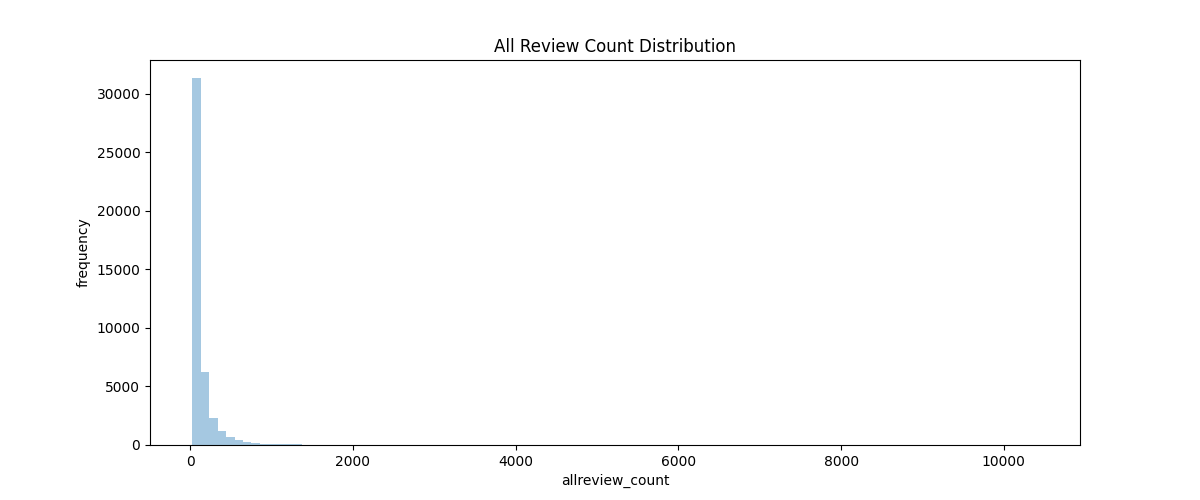

In [36]:
pd_avg_reviews = avg_reviews.toPandas()
fig = plt.figure(figsize=(12,5))
ax = sns.distplot(pd_avg_reviews['allreview_count'], hist=True, bins=100, kde=False).set_title('All Review Count Distribution')
plt.xlabel("allreview_count")
plt.ylabel("frequency")
plt.show()
%matplot plt

In [37]:
pd_avg_reviews['allreview_count'].mode()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0    25
dtype: int64

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

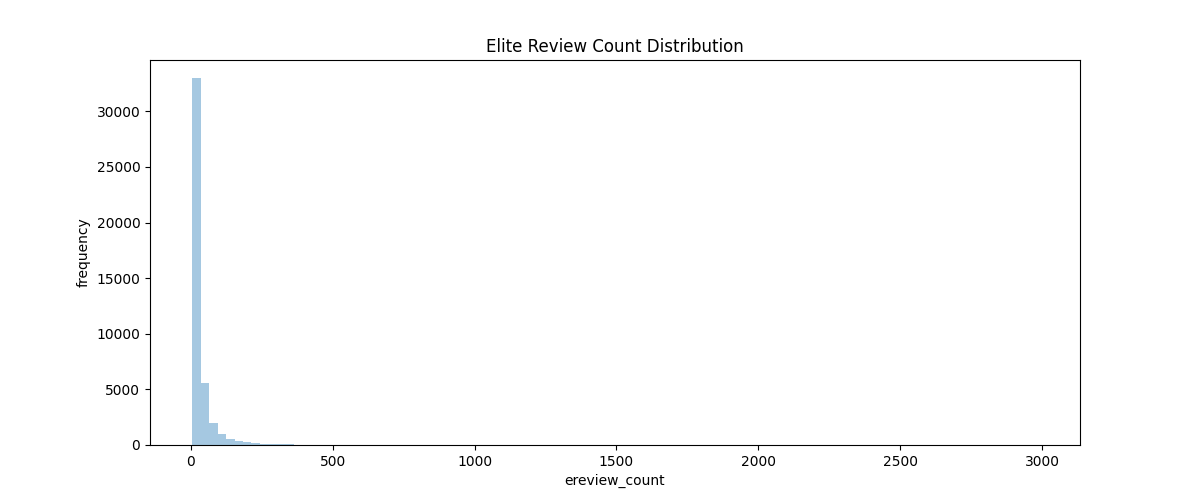

In [38]:
fig = plt.figure(figsize=(12,5))
ax = sns.distplot(pd_avg_reviews['ereview_count'], hist=True, bins=100, kde=False).set_title('Elite Review Count Distribution')
plt.xlabel("ereview_count")
plt.ylabel("frequency")
plt.show()
%matplot plt

Let's take a look at the difference between average elite rating and average rating:

In [39]:
avg_reviews = avg_reviews.withColumn('delta', (col('avg_e_stars') - col('avg_stars')))
avg_reviews.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+------------------+-------------+---------------+------------------+-------------------+
|         business_id|avg_stars|       avg_e_stars|ereview_count|allreview_count|  elite_percentage|              delta|
+--------------------+---------+------------------+-------------+---------------+------------------+-------------------+
|--9e1ONYQuAa-CB_R...|      4.0|4.1916058394160585|          548|           1816|30.176211453744493|0.19160583941605847|
|-0ZO00Vm2ADchytlE...|      5.0|               5.0|            8|             86|  9.30232558139535|                0.0|
|-1VaIJza42Hjev6uk...|      4.0| 3.793103448275862|           29|            280|10.357142857142858|-0.2068965517241379|
|-2Arz8twKJmxHMS3S...|      4.0|               3.7|           10|             34|29.411764705882355|-0.2999999999999998|
|-2ToCaDFpTNmmg3QF...|      1.5|          2.109375|           64|            464|13.793103448275861|           0.609375|
|-2wh_ZsD2n5xFYgzp...|      4.0|

Now, let's look at the distribution of this delta:

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

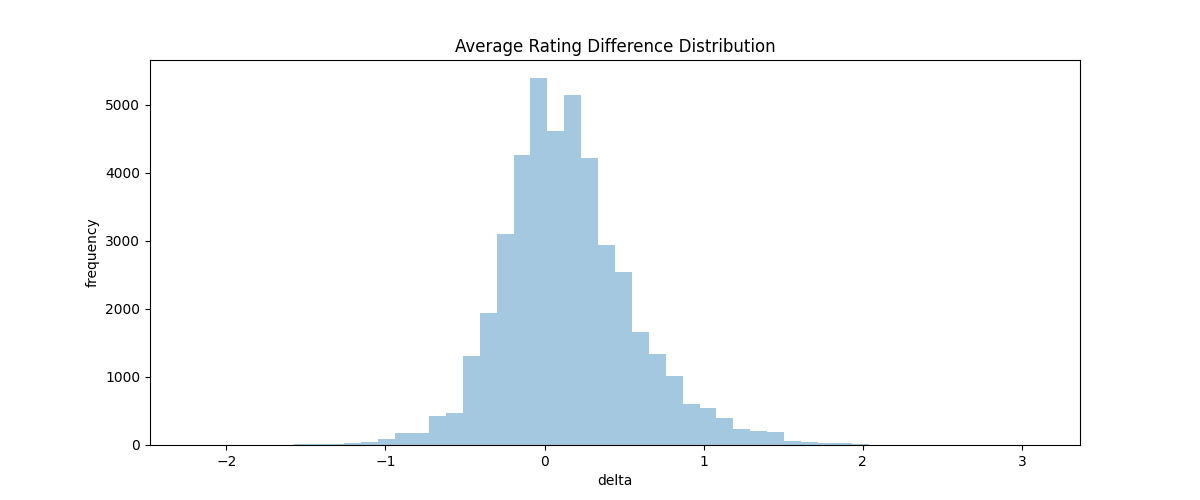

In [40]:
pd_avg_reviews = avg_reviews.toPandas()
fig = plt.figure(figsize=(12,5))
ax = sns.distplot(pd_avg_reviews['delta'], hist=True, kde=False).set_title('Average Rating Difference Distribution')
plt.xlabel("delta")
plt.ylabel("frequency")
plt.show()
%matplot plt

We see that the difference between average elite reviews and average total reviews is normally distributed. There might be some skewness to the right. We will first look at the summary of the distribution: 

In [41]:
avg_reviews.select('delta').summary().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+
|summary|               delta|
+-------+--------------------+
|  count|               43291|
|   mean|   0.149063831943786|
| stddev| 0.42068188793625066|
|    min| -2.2142857142857144|
|    25%|-0.11538461538461542|
|    50%| 0.11224489795918347|
|    75%|               0.375|
|    max|  3.0999999999999996|
+-------+--------------------+

From an initial glance, we see that the mean is around 0.15 which suggests that elite users give a rating of 0.15 stars higher than the average of total users' ratings. The standard deviation is 0.42 which suggests that we should perform a hypothesis test in order to statistically reject the null hypothesis (average rating of elite users equals the average rating of all users).

### Hypothesis Testing
#### 1. Determine a null and alternate hypothesis:
* Null Hypothesis: Average rating of elite users and all users are the same <br>
* Alternate Hypothesis: Average rating of elite users and all users are different

#### 2. Sample size
From the summary above of the dataset, the sample size for our test is 43291. (N = 43291)

In [42]:
N = 43291

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 3. Determine a confidence interval and degrees of freedom
We select α = 0.05 - there is 95% confidence that the conclusion of this test will be valid. <br>
Degree of freedom: <br>
df = sample size (elite users) + sample size (all users) -2  = 43291 + 43291 - 2

In [43]:
degree_freedom = 2*avg_reviews.count() - 2

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
print(degree_freedom)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

86580

#### 4. Calculate standard deviation
##### Calculate the variance

In [45]:
from pyspark.sql.functions import var_samp
var_elite = avg_reviews.select(var_samp("avg_e_stars")).head()[0]
var_all = avg_reviews.select(var_samp("avg_stars")).head()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
print(var_elite)
print(var_all)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.3452650552068847
0.4929086981765366

##### Calculate the standard deviation

In [47]:
s = np.sqrt((var_elite + var_all)/2)
print(s)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.6473691965885546

#### 5. Calculate the t-statistics

In [48]:
# From our statistic summary of dataset
mean_elite = 3.781319959083376
mean_all = 3.6322561271395903
t = (mean_elite - mean_all)/(s*np.sqrt(2/N))
print(t)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

33.876931165656266

#### 6. Compare with critical value
##### p-value after comparison with t

In [49]:
p = 1 - stats.t.cdf(t,df=degree_freedom)
print("t = " + str(t))
print("p = " + str(2*p))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

t = 33.876931165656266
p = 0.0

After comparing the t statistic with the critical t value (using the stats module), we obtained a p value of 0.0. A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, as there is less than a 5% probability the null is correct (and the results are random). 

##### Therefore, we reject the null hypothesis, and accept the alternative hypothesis. Thus, it proves that the average rating of elite users and all users are different and that the elite reviewers should not be trusted. 
